# Isotropic Hyperelasticity

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/Drenderer/klax/blob/main/docs/examples/isotropic_hyperelasticity.ipynb)

This notebook implements and calibrates an neural network-based isotropic, incompressible hyperelastic material model to Treloar's experimental data using the method presented in [Dammaß et al. (2025)](https://doi.org/10.48550/arXiv.2503.20598). It showcases the basic use of `klax`'s input covex neural network (`FICNN`) and `klax.fit()` function for building and calibrating physics-augmented neural network models.

To run it locally install klax with plotting capability via `pip install 'klax[plot]'`.

We start by importing the required packages for model creation, optimization and plotting. We also import some type aliases and import the `dataclass` module for some simple data handling.

In [1]:
from dataclasses import dataclass

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
from jaxtyping import Array, Float
from matplotlib import pyplot as plt

import klax

We start by defining a basic class `LoadCase`. It consists of an array of princible stretches `stretch` with shape `(dim, 3)` and the (1,1) component of the first Piola-Kirchhoff stress tensor with shape `(dim, 1)`, where `dim` denotes the number of data points in the load case. We also define a descriptive `title`, which will be used for plotting later on.

In [2]:
@dataclass
class LoadCase:
    """A simple load case."""

    stretch: Float[Array, "dim 3"]
    pk11_stress: Float[Array, "dim 1"]
    title: str

In the following, three load cases for *uniaxial tension*, *biaxial tension*, and *pure shear* are created. The data corresponds to Treloar`s experimental results, which were obtained from testing of a rubber material.

In [3]:
# Uniaxial load case
stretch_1 = jnp.array(
    [
        1.0,
        1.01,
        1.12,
        1.24,
        1.39,
        1.61,
        1.89,
        2.17,
        2.42,
        3.01,
        3.58,
        4.03,
        4.76,
        5.36,
        5.76,
        6.16,
        6.4,
        6.62,
        6.87,
        7.05,
        7.16,
        7.27,
        7.43,
        7.5,
        7.61,
    ]
)
pk11_stress = jnp.array(
    [
        0.0,
        0.03,
        0.14,
        0.23,
        0.32,
        0.41,
        0.5,
        0.58,
        0.67,
        0.85,
        1.04,
        1.21,
        1.58,
        1.94,
        2.29,
        2.67,
        3.02,
        3.39,
        3.75,
        4.12,
        4.47,
        4.85,
        5.21,
        5.57,
        6.3,
    ]
)
stretch = jnp.stack(
    [stretch_1, stretch_1 ** (-0.5), stretch_1 ** (-0.5)], axis=-1
)

uniaxial = LoadCase(stretch, pk11_stress, "Uniaxial tension")

# Biaxial load case
stretch_1 = jnp.array(
    [
        1.0,
        1.04,
        1.08,
        1.12,
        1.14,
        1.2,
        1.31,
        1.42,
        1.69,
        1.94,
        2.49,
        3.03,
        3.43,
        3.75,
        4.03,
        4.26,
        4.44,
    ]
)
pk11_stress = jnp.array(
    [
        0.0,
        0.09,
        0.16,
        0.24,
        0.26,
        0.33,
        0.44,
        0.51,
        0.65,
        0.77,
        0.96,
        1.24,
        1.45,
        1.72,
        1.96,
        2.22,
        2.43,
    ]
)
stretch = jnp.stack([stretch_1, stretch_1, stretch_1 ** (-2)], axis=-1)

biaxial = LoadCase(stretch, pk11_stress, "Biaxial tension")

# Pure shear load case
stretch_1 = jnp.array(
    [
        1.0,
        1.06,
        1.14,
        1.21,
        1.32,
        1.46,
        1.87,
        2.4,
        2.98,
        3.48,
        3.96,
        4.36,
        4.69,
        4.96,
    ]
)
pk11_stress = jnp.array(
    [
        0.0,
        0.07,
        0.16,
        0.24,
        0.33,
        0.42,
        0.59,
        0.76,
        0.93,
        1.11,
        1.28,
        1.46,
        1.62,
        1.79,
    ]
)
stretch = jnp.stack(
    [stretch_1, jnp.ones_like(stretch_1), stretch_1 ** (-1)], axis=-1
)

pure_shear = LoadCase(stretch, pk11_stress, "Pure shear")

Next, the neural network-based isotropic, incompressible hyperelastic material model according to Dammaß et al. is implemented.

In [4]:
class PANN(eqx.Module):
    """An neural-network based potential for incompressible hyperelasticity."""

    icnn: klax.nn.FICNN

    def __init__(self, *, key):
        self.icnn = klax.nn.FICNN(
            2,
            "scalar",
            1 * [8],
            use_passthrough=True,
            non_decreasing=True,
            key=key,
        )

    def __call__(self, stretch: Array) -> Array:
        """Evaluate the (1,1) compontent of the first Piola-Kirchhoff stress."""
        stress_coefficients = self.stress_coefficients(stretch)
        return self.piola_kirchhoff_stress(stretch, stress_coefficients)

    def potential(self, isochoric_invariants: Array) -> Array:
        """Compute the hyperelastic potential with energy normalization."""
        # Compute normalization term for F = I
        isochoric_invariants_iden = jnp.array([3, 4])
        pot_iden = self.icnn(isochoric_invariants_iden)
        return self.icnn(isochoric_invariants) - pot_iden

    def isochoric_invariants(self, stretch: Array) -> Array:
        """Compute the isotropic, isochoric invariants."""
        i1 = stretch[0] ** 2 + stretch[1] ** 2 + stretch[2] ** 2
        i2 = (
            (stretch[0] * stretch[1]) ** 2
            + (stretch[0] * stretch[2]) ** 2
            + (stretch[1] * stretch[2]) ** 2
        )
        j = stretch[0] * stretch[1] * stretch[2]

        i1_ = j ** (-2 / 3) * i1
        i2_ = j ** (-4 / 3) * i2
        return jnp.array([i1_, i2_])

    def stress_coefficients(self, stretch: Array) -> Array:
        """Compute the stress coefficients from the potential.

        They correspond to the gradient of the potential with respect to the
        isochoric invariants.
        """
        isochoric_invariants = self.isochoric_invariants(stretch)
        return jax.grad(self.potential)(isochoric_invariants)

    def piola_kirchhoff_stress(
        self, stretch: Array, stress_coefficients: Array
    ):
        """Compute the (1,1) component of the Piola-Kirchoff stress."""
        return 2.0 * (
            stress_coefficients[0]
            * (stretch[0] - stretch[2] ** 2 * stretch[0] ** (-1))
            + stress_coefficients[1]
            * (
                stretch[0] * (stretch[1] ** 2 + stretch[2] ** 2)
                - stretch[2] ** 2
                * stretch[0] ** (-1)
                * (stretch[0] ** 2 + stretch[1] ** 2)
            )
        )

We choose the *uniaxial* and *biaxial* load cases as calibration data and fit the `PANN` model using `fit()` with the following arguments:

The first argument corresponds to the model that shall be optimized. Its followed by the `data` argument, which could be any PyTree containing at least one Array. However, to use `klax`'s building loss functions the arguments must be of the form `(x, y)`, where both `x` and `y` are the input and output Array respectively.

Next, we specify the number of samples per batch and the axis along which `x` and `y` shall be batched, by setting the `batch_size` and `batch_axis` arguments, respectively.

A loss function is defined using the `loss_fn` argument.

We can select an optimization algorithm by passing any `optax.GradientTransformation` object to the `optimizer` argument. Likewise we can pass a custom `Callback` to the `history` argument to record intermediate training results. In this case we are passing the default `HistoryCallback` with a value of `1000`, which ensures that loss-values are only computed after every 1000-th step, to reduce computational cost.

Finally, a random `key` needs to be passed, which is used internally by the batch generation algorithm.

If required, `fit()` delivers many more advanded capabilities such as passing validation data, defining custom batch axes/loss functions/batch generators as well as the use of `Callbacks` and optimizer states. See the documentation of `fit()` reference for the full list of options.

After finishing calibration, the loss evluation can be plotted by calling the `HistoryCallback.plot()` method on our returne `history` object.


Step: 0, Loss: 1.805e+02
Step: 1000, Loss: 1.477e-01
Step: 2000, Loss: 4.639e-02
Step: 3000, Loss: 2.253e-02
Step: 4000, Loss: 1.403e-02
Step: 5000, Loss: 1.052e-02
Step: 6000, Loss: 8.006e-03
Step: 7000, Loss: 7.186e-03
Step: 8000, Loss: 7.112e-03
Step: 9000, Loss: 6.341e-03
Step: 10000, Loss: 5.949e-03
Step: 11000, Loss: 6.724e-03
Step: 12000, Loss: 5.951e-03
Step: 13000, Loss: 6.671e-03
Step: 14000, Loss: 5.807e-03
Step: 15000, Loss: 6.013e-03
Step: 16000, Loss: 6.004e-03
Step: 17000, Loss: 5.959e-03
Step: 18000, Loss: 5.910e-03
Step: 19000, Loss: 6.117e-03
Step: 20000, Loss: 5.688e-03
Training took: 0:00:17.094651


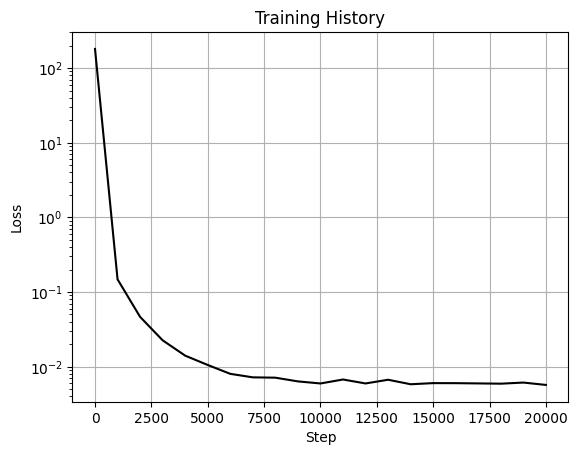

In [5]:
key = jrandom.PRNGKey(0)
keys = jrandom.split(key, 2)

model = PANN(key=keys[0])
x = jnp.concatenate((uniaxial.stretch, biaxial.stretch), axis=0)
y = jnp.concatenate((uniaxial.pk11_stress, biaxial.pk11_stress), axis=0)

model, history = klax.fit(
    model,
    (x, y),
    batch_size=32,
    batch_axis=0,
    steps=20_000,
    loss_fn=klax.mse,
    optimizer=optax.adam(2e-3),
    history=klax.HistoryCallback(1000),
    key=keys[1],
)

history.plot()

A simple utility function is defined to `evaluate` the calibared `model` on a tuple of load cases. Here, the model is jit-compiled using `eqx.filter_jit()` in order to speed up evaluation for large amounts of data.

In [6]:
def evaluate(model, load_cases: tuple[LoadCase, ...]):
    model = eqx.filter_jit(model)
    _, axs = plt.subplots(1, len(load_cases), figsize=(5 * len(load_cases), 5))

    def plot(ax, x, y, y_pred, title):
        ax.plot(x, y, "x", label="data", color="black")
        ax.plot(x, y_pred, "-", label="data", color="blue")
        ax.set_xlabel(r"$\lambda_1$")
        ax.set_ylabel(r"$P_{11}$/ MPa")
        ax.set_title(title)

    for ax, lc in zip(axs, load_cases):
        pk11_stress_pred = jax.vmap(model)(lc.stretch)
        plot(ax, lc.stretch[:, 0], lc.pk11_stress, pk11_stress_pred, lc.title)

We evaluate the model on the two training cases (*uniaxial*, *biaxial*) and on the *pure shear* test case. Note, that the model needs to be made callable using `klax.finalize`, since the `FICNN` module contains parameters of type `Unwrappable`, which need to be unwrapped before evaluation.

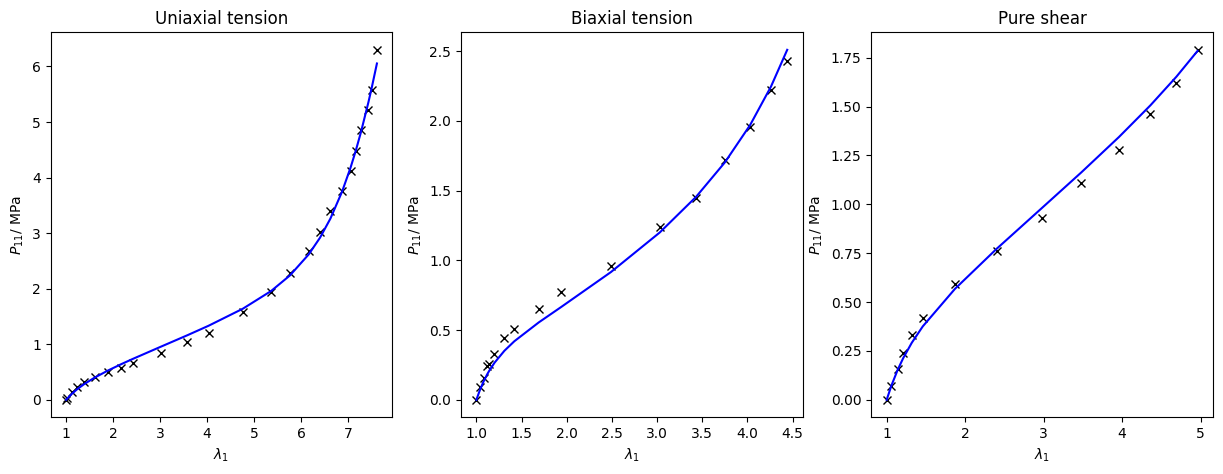

In [7]:
model_ = klax.finalize(model)
evaluate(model_, (uniaxial, biaxial, pure_shear))

Finally, the model parameters can be saved using Equinox's [`equinox.tree_serialize_leaves`](https://docs.kidger.site/equinox/api/serialisation/#equinox.tree_serialise_leaves) function. By default it exports to JAX's or Numpy's binary file format. However, to apply the trained model in a finite element simulation (FEM), we usually need to export the parameters in a more universal format.

For this, the `klax.text_serialize_filter_spec` and `klax.text_deserialize_filter_spec` filter specifications are used, which enable exporting and reading parameters from text files.

In [8]:
# Save the model parameters to a text file
eqx.tree_serialise_leaves(
    "model.txt", model, filter_spec=klax.text_serialize_filter_spec
)

# Load the model parameters from a text file
loaded_model = eqx.tree_deserialise_leaves(
    "model.txt", model, filter_spec=klax.text_deserialize_filter_spec
)

eqx.tree_pprint(loaded_model)

PANN(
  icnn=FICNN(
    layers=(
      Linear(
        weight=NonNegative(parameter=f32[2,8]),
        bias=f32[8],
        in_features=2,
        out_features=8,
        use_bias=True
      ),
      InputSplitLinear(
        weights=(
          NonNegative(parameter=f32[8,1]), NonNegative(parameter=f32[2,1])
        ),
        bias=f32[1],
        in_features=(8, 2),
        out_features='scalar',
        use_bias=True,
        _num_inputs=2
      )
    ),
    activations=(<PjitFunction of <function softplus at 0x000001D34E9CB1A0>>,),
    final_activation=<function FICNN.<lambda>>,
    use_bias=True,
    use_final_bias=True,
    use_passthrough=True,
    non_decreasing=True,
    in_size=2,
    out_size='scalar',
    width_sizes=(8,)
  )
)
